In [45]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [46]:
data_dir = r'E:\comp_vision\BG_G_NG'

classes = os.listdir(data_dir)
print(classes)

['bg_G', 'bg_NG']


In [47]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((640,640)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: bg_G (Class No: 0)


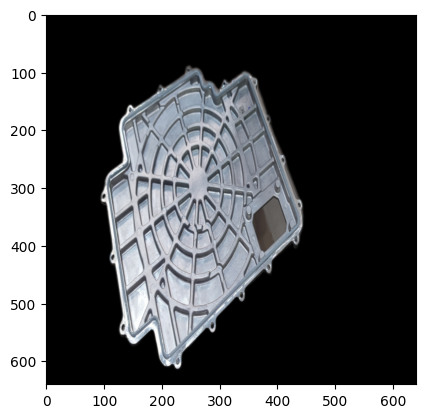

In [49]:
img, label = dataset[12]
show_sample(img, label)

In [50]:
random_seed = 42
torch.manual_seed(random_seed)

In [51]:
len(dataset)

203

In [52]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [53]:
from torch.utils.data.dataloader import DataLoader
batch_size = 16

In [54]:
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers = 4, pin_memory = True)

In [55]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

In [56]:
#show_batch(train_dl)

In [57]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [58]:
dataset.classes

['bg_G', 'bg_NG']

In [59]:
import torch.nn as nn
import torchvision.models as models

class VGG19BinaryClassifier(ImageClassificationBase):
    def __init__(self, num_classes=1):
        super(VGG19BinaryClassifier, self).__init__()

        # Load the pre-trained VGG19 model
        vgg19_model = models.vgg19(pretrained=True)

        # Freeze the convolutional layers (features)
        for param in vgg19_model.features.parameters():
            param.requires_grad = False

        # Extract the convolutional layers
        self.features = vgg19_model.features

        # Add your own fully connected layers for binary classification
        self.classifier = nn.Sequential(
            nn.Linear(204800, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, len(dataset.classes)),
            nn.Sigmoid()  # Use sigmoid activation for binary classification
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Create an instance of the VGG19BinaryClassifier
model = VGG19BinaryClassifier()

# Print the model architecture
print(model)


c:\Users\167093\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\167093\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG19BinaryClassifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), s

In [60]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [61]:
device = get_default_device()
device

device(type='cpu')

In [62]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

VGG19BinaryClassifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), s

In [63]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [64]:
model = to_device(VGG19BinaryClassifier(), device)

In [65]:
evaluate(model, val_dl)

{'val_loss': 0.6929407715797424, 'val_acc': 0.5763888955116272}

In [66]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

In [67]:
num_epochs = 60
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 0.6753, val_loss: 0.6647, val_acc: 0.5104
Epoch 2: train_loss: 0.5605, val_loss: 0.5943, val_acc: 0.6771
Epoch 3: train_loss: 0.3829, val_loss: 0.5889, val_acc: 0.6615
Epoch 4: train_loss: 0.3349, val_loss: 0.5361, val_acc: 0.6840
Epoch 5: train_loss: 0.3193, val_loss: 0.5174, val_acc: 0.7951
Epoch 6: train_loss: 0.3152, val_loss: 0.5069, val_acc: 0.7951
Epoch 7: train_loss: 0.3141, val_loss: 0.5045, val_acc: 0.7951
Epoch 8: train_loss: 0.3136, val_loss: 0.5110, val_acc: 0.8264
Epoch 9: train_loss: 0.3137, val_loss: 0.5103, val_acc: 0.8108
Epoch 10: train_loss: 0.3134, val_loss: 0.5101, val_acc: 0.7951
Epoch 11: train_loss: 0.3134, val_loss: 0.5097, val_acc: 0.8108
Epoch 12: train_loss: 0.3135, val_loss: 0.5098, val_acc: 0.7951
Epoch 13: train_loss: 0.3135, val_loss: 0.5082, val_acc: 0.8108
Epoch 14: train_loss: 0.3134, val_loss: 0.5071, val_acc: 0.8108
Epoch 15: train_loss: 0.3134, val_loss: 0.5064, val_acc: 0.7951
Epoch 16: train_loss: 0.3134, val_loss: 0.5064, v

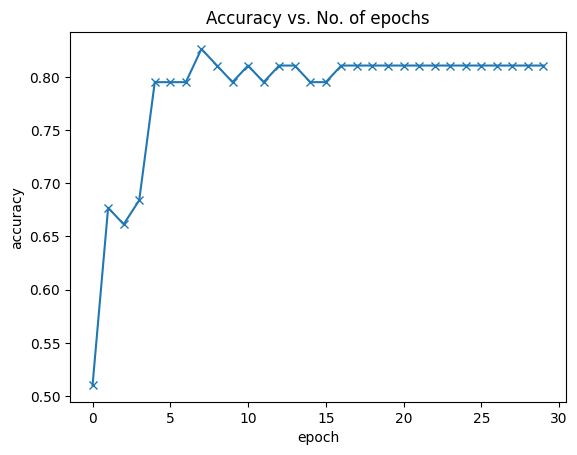

In [68]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

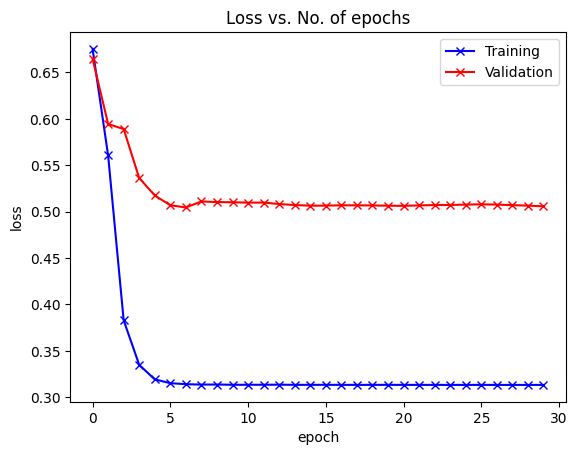

In [69]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [70]:
import joblib
joblib.dump(model, 'bg_g_ng3.joblib')

['bg_g_ng3.joblib']

In [71]:
model_2=joblib.load('bg_g_ng3.joblib')

In [72]:
import torch
import torchvision.models as models
from torchvision import transforms
import h5py

resnet_model=models.vgg19(pretrained=False)
model_2.eval()

c:\Users\167093\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG19BinaryClassifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), s

In [73]:
load= model_2

tensor([0.6068], grad_fn=<MaxBackward0>)
Predicted Class: bg_G


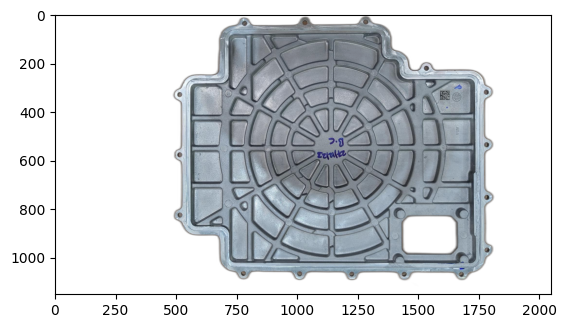

In [88]:
from PIL import Image
from torchvision.transforms import ToTensor
from rembg import remove
import torchvision
import torch

# Assuming you have the predict_image function defined
def predict_image(img, model):
    # Ensure the image has 3 channels
    if img.shape[0] != 3:
        raise ValueError("Input image must have 3 channels.")

    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), 'cpu')

    # Get predictions from the model
    yb = model(xb)

    # Pick index with the highest probability
    prob, preds = torch.max(yb, dim=1)
    print(prob)

    # Retrieve the class label
    return dataset.classes[preds[0].item()]

# Load the image
image_path = r"C:\Users\167093\Downloads\MicrosoftTeams-image.png"
image = Image.open(image_path)
from rembg import remove
output = remove(image)

output.save('output.png')

image2 = Image.open(r'E:\comp_vision\output.png')

plt.imshow(output)

# Remove the alpha channel if present
if output.mode == 'RGBA':
    image1 = image2.convert('RGB')

else:
    image1=image2

# Resize the image
image1 = image1.resize((640, 640))

# Convert the image to a tensor
image_tensor = ToTensor()(image1)

# Assuming 'load' is your model and 'your_dataset' is your dataset
result = predict_image(image_tensor, load)

print(f"Predicted Class: {result}")